In [70]:
import numpy as np
import codecs
import nltk
import lda
import sklearn
import string
import cPickle as pickle
import matplotlib.pyplot as plt
import collections, operator
import pandas as pd
import seaborn as sns
from matplotlib import animation
from scipy.special import gammaln
from nltk.corpus import stopwords
from nltk.stem.porter import *
from collections import Counter, defaultdict
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from collections import defaultdict
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter
# from wordcloud import WordCloud
plt.style.use("ggplot"); plt.style.use("bmh");
%matplotlib inline

#AM 207 Final Project
### Cole Diamond
### Raphael Pestourie
### Wei Dai

#Collapsed Gibbs Sampler for LDA to Classify Books by Thematic Content
<hr/>


# 1. Introduction 

LDA is a generative probabilistic model for collections of grouped discrete data. Each group is described as a random mixture over a set of latent topics where each topic is a discrete distribution over the collection’s vocabulary.  We use Gibbs sampling to sample from the posterior of the distribution described by LDA to extract thematic content from ten classic novels. We train on half of the pages, and perform inference on the remainder. We use nearest neighbor on the queried topic distibution to query the closest match. We were able to correctly label 100% of our test data with the correct title.



# 2. Methodology

##2.1. Pre-processing

* Our first step is to load the data from a folder containing all ten of the classic novels which compose our training corpus

In [71]:
import codecs
books = ["beowulf.txt", "divine_comedy.txt", "dracula.txt", "frankenstein.txt", "huck_finn.txt", "moby_dick.txt", "sherlock_holmes.txt", "tale_of_two_cities.txt", "the_republic.txt", "ulysses.txt"]
all_docs = []
for book in books:
    with codecs.open('data/%s'%(book), 'r', encoding='utf-8') as f:
        lines = f.read().splitlines() 
        all_docs.append(" ".join(lines))

- We remove punctuation and numbers from our books.
- Additionally, we remove stop words, or words that don't have much lexical meaning, ie: "the, is, at, which, on...". 

In [72]:
stemmer = PorterStemmer()

def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def preprocess(doc):
    doc = doc.lower()
    no_punctuation = re.sub(r'[^a-zA-Z\s]','',doc)
    tokens = nltk.word_tokenize(no_punctuation)
    filtered = [w for w in tokens if not w in stopwords.words('english')]
    #stemmed = stem_tokens(filtered, stemmer)
    #return stemmed
    return filtered

processed_docs = np.array(map(preprocess, all_docs))

In [73]:
processed_docs[0][500:510]

[u'tread',
 u'warrior',
 u'mail',
 u'viii',
 u'english',
 u'translations',
 u'beowulf',
 u'professor',
 u'garnett',
 u'alone']

In [74]:
np.save("temp_data/processed_docs.npy", processed_docs)

In [75]:
processed_docs = np.load("temp_data/processed_docs.npy")

## Build vocabulary 

In [76]:
vocab = np.unique(np.hstack(processed_docs.flat))
vocab_dict = {}
inv_vocab_dict = {}
for idx, w in enumerate(vocab):
    vocab_dict[w] = idx
    inv_vocab_dict[idx] = w

In [77]:
vocab[np.random.choice(vocab.size, 10)]

array([u'strainings', u'cassock', u'repulsive', u'yearn', u'fortyrod',
       u'coated', u'juridical', u'schism', u'toque', u'forfeit'], 
      dtype='<U69')

##Map Docs to Vocab

- We now translate our documents into the language of numbers, allowing us to perform operations on our data

In [78]:
docs_as_nums = map(lambda doc: [vocab_dict[w] for w in doc], processed_docs)
docs_as_nums[0][:10]

[39038, 22075, 15318, 4485, 15318, 53645, 1932, 1940, 10849, 1375]

## Build Training and Test Set

- We split each of the books in half to use a training data and as test data, respectively.

In [79]:
test_docs, train_docs = [], []
for doc in docs_as_nums:
    test_docs.append(np.array(doc[0:len(doc)/2]))
    train_docs.append(np.array(doc[len(doc)/2:]))
test_docs, train_docs = np.array(test_docs), np.array(train_docs)

In [80]:
test_docs

array([[39038, 22075, 15318, ..., 52726, 24170, 31510],
       [39038, 22076, 14172, ..., 34942, 50589, 40437],
       [39038, 22075, 15318, ...,  1298, 34140, 26381],
       ..., 
       [39038, 22075, 15318, ...,  5316, 28670, 51083],
       [39038, 22075, 15318, ..., 52065, 34942, 56594],
       [39038, 22075, 15318, ..., 54765, 12386, 14418]])

## Build a Count Matrix

A count matrix is built by setting each row equal to the number of times a vocabulary word is used in a document. The count matrix has dimensions (num_docs x size_of_vocab). We need the count matrix because our LDA function will take it as an input.

In [112]:
def freq_map(doc):
    out = np.zeros(vocab.size, dtype=np.int32)
    for w in doc:
        out[w] += 1
    return out
train_count_mat = np.array(map(freq_map, train_docs), dtype=np.int32)
test_count_mat = np.array(map(freq_map, test_docs), dtype=np.int32)

In [82]:
train_count_mat

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [83]:
np.save("temp_data/train_count_mat.npy", train_count_mat)
np.save("temp_data/test_count_mat.npy", test_count_mat)

In [84]:
train_count_mat = np.load("temp_data/train_count_mat.npy")
test_count_mat = np.load("temp_data/test_count_mat.npy")

<hr/>
##2. LDA with Gibbs Sampling


LDA is a generative probabilistic model for collections of grouped discrete data. Each group is described as a random mixture over a set of latent topics where each topic is a discrete distribution over the collection’s vocabulary.  Algorithm 1 delineates how we can draw from the posterior of the LDA model using Gibbs Sampling

We define the following parameters whose relationship is described by the plate notation in Figure 1.

* α is the parameter of the Dirichlet prior on the per-document topic distributions,
* β is the parameter of the Dirichlet prior on the per-topic word distribution,
* $\theta_i$ is the topic distribution for document i,
* $\phi_k$ is the word distribution for topic k,
* $z_{ij}$ is the topic for the jth word in document i, and
* $w_{ij}$ is the specific word.


<img src="ipynb_assets/LDA Graph.png" height=300 style="float:left;">
<img src="ipynb_assets/LDA Gibbs.png" height=300>

* First, let's define our conditional distribution

In [85]:
def conditional_dist(alpha, beta, nwt, nd, nt, d, w):
    """
    Compute the conditional distribution
    """
    W = nwt.shape[0]
    p_z =  (ndt[d,:] + alpha) * ((nwt[w,:] + beta) / (nt + beta * W))
    # normalization
    p_z /= np.sum(p_z)
    return p_z

* We'll also need the log likelihood to verify that our model is converging

<img src="ipynb_assets/likelihood.png" height="75" >
<img src="ipynb_assets/multinomial beta.png" height="30">

In [86]:
def log_likelihood(alpha, beta, nwt, ndt, n_topics):
    """
    Compute the likelihood that the model generated the data.
    """
    W = nwt.shape[0]
    n_docs = ndt.shape[0]
    likelihood = 0

    for t in xrange(n_topics):
        likelihood += log_multinomial_beta(nwt[:,t]+beta) - log_multinomial_beta(beta, W)

    for d in xrange(n_docs):
        likelihood += log_multinomial_beta(ndt[d,:]+alpha) - log_multinomial_beta(alpha, n_topics)

    return likelihood

def log_multinomial_beta(alpha, K=None):
    """
    Logarithm of the multinomial beta function.
    """
    if K is None:
        return np.sum(gammaln(alpha)) - gammaln(np.sum(alpha))
    else:
        return K * gammaln(alpha) - gammaln(K*alpha)

- Since our input is a count matrix, we need to recover our document by multiplying the token by its frequency and combining (in any order since we have a bag of words assumption)

In [87]:
def word_indices(arr):
    """
    Transform a row of the count matrix into a document by replicating the token by its frequency
    """
    for idx in arr.nonzero()[0]:
        for i in xrange(int(arr[idx])):
            yield idx

- To perform LDA with Gibbs Sampling we need to initialize z randomly and initialize our counters.
- We set the number of topics to 1000.

In [88]:
n_topics = 15
alpha = .1 # prior weight of topic k in a document; few topics per document
beta = 0.05 # prior weight of word w in a topic; few words per topic
n_docs, W = train_count_mat.shape
# number of times document m and topic z co-occur
ndt = np.zeros((n_docs, n_topics))
# number of times word w and topic z co-occur
nwt = np.zeros((W, n_topics))
nd = np.zeros(n_docs)
nt = np.zeros(n_topics)
iters = 25
topics = defaultdict(dict)
delta_topics = []
delta_doc_topics = defaultdict(list)
likelihoods = []

for d in xrange(n_docs):
    # i is a number between 0 and doc_length-1
    # w is a number between 0 and W-1
    for i, w in enumerate(word_indices(train_count_mat[d, :])):
        # choose an arbitrary topic as first topic for word i
        t = np.random.randint(n_topics)
        ndt[d,t] += 1
        nd[d] += 1
        nwt[w,t] += 1
        nt[t] += 1
        topics[d][i] = t

* Now, we do Gibbs sampling for 25 iterations

In [89]:
# for each iteration
for it in xrange(iters):
    delta_topics_iteration = 0
    # for each doc
    for d in xrange(n_docs): 
        delta_doc_topics_iteration = 0
        # for each word
        for i, w in enumerate(word_indices(train_count_mat[d, :])):
            # get topic of mth document, ith word
            t = topics[d][i] 
            # decrement counters
            ndt[d,t] -= 1; nd[d] -= 1; nwt[w,t] -= 1; nt[t] -= 1

            p_z = conditional_dist(alpha, beta, nwt, nd, nt, d, w)
            t = np.random.multinomial(1,p_z).argmax()
            
            # increment counters
            ndt[d,t] += 1; nd[d] += 1; nwt[w,t] += 1; nt[t] += 1; 
            # increment convergence counter if the value for topic changes
            if topics[d][i] != t:
                delta_doc_topics_iteration += 1
                delta_topics_iteration += 1
                
            topics[d][i] = t
            
        delta_doc_topics[d].append(delta_doc_topics_iteration)
        
        
    print "-"*50, "\n Iteration", it+1, "\n", "-"*50, "\n"
    likelihood = log_likelihood(alpha, beta, nwt, ndt, n_topics)
    print "Likelihood", likelihood
    likelihoods.append(likelihood)
    print "Delta topics", delta_topics_iteration, "\n"
    delta_topics.append(delta_topics_iteration)
    

-------------------------------------------------- 
 Iteration 1 
-------------------------------------------------- 

Likelihood -4038193.89598
Delta topics 313850 

-------------------------------------------------- 
 Iteration 2 
-------------------------------------------------- 

Likelihood -3947865.28758
Delta topics 287556 

-------------------------------------------------- 
 Iteration 3 
-------------------------------------------------- 

Likelihood -3890047.04914
Delta topics 272139 

-------------------------------------------------- 
 Iteration 4 
-------------------------------------------------- 

Likelihood -3842723.73349
Delta topics 260829 

-------------------------------------------------- 
 Iteration 5 
-------------------------------------------------- 

Likelihood -3793436.05324
Delta topics 250828 

-------------------------------------------------- 
 Iteration 6 
-------------------------------------------------- 

Likelihood -3737449.70273
Delta topics 239200 

<hr/>
#3. Analysis


### Log Likelihood
We verify that the likelihood that our model generated the data increases over ever iteration. For convergence, we want to see a plateau, such that we are seeing diminishing gains in our log likelihood. As the graph below illustrates, this is exactly the case.

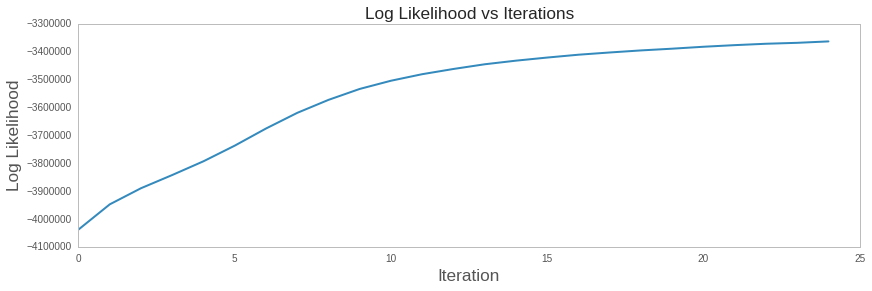

In [90]:
ax = plt.figure(figsize=(14,4))
plt.plot(np.arange(iters), likelihoods)
plt.title("Log Likelihood vs Iterations", fontsize="xx-large")
plt.xlabel("Iteration", fontsize="xx-large")
plt.ylabel("Log Likelihood", fontsize="xx-large")
plt.show()

### Aggregate Word-Topic Assignment Swaps
We present a custom statistic to measure the total number of words whose topic assignment changed between iterations. We know that if the algorithm converges, the number of swaps every iteration should level out. The graph below illustrates this trend.

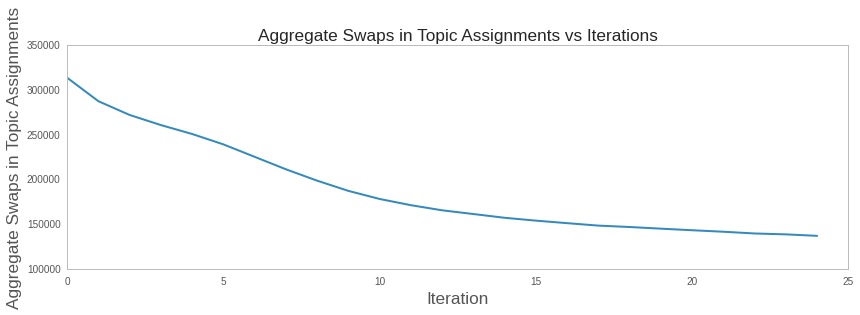

In [91]:
plt.figure(figsize=(14,4))
plt.plot(np.arange(iters), delta_topics)
plt.title("Aggregate Swaps in Topic Assignments vs Iterations", fontsize="xx-large")
plt.xlabel("Iteration", fontsize="xx-large")
plt.ylabel("Aggregate Swaps in Topic Assignments", fontsize="xx-large")
plt.show()

### Aggregate Word-Topic Assignment Swaps per Document
We apply the word-topic assignment swaps to a per-document basis. We should still see that on a document granularity, word-topic assignments should plateau. Each of the ten documents below illustrate this trend

In [92]:
# plt.figure(figsize=(16,25))
# gs = gridspec.GridSpec(5, 2)
                       
# for i in range(len(books)):
#     ax = plt.subplot(gs[i])
#     ax.plot(np.arange(iters), delta_doc_topics[i])
#     ax.set_title("Aggregate Swaps in Topic Assignments vs Iterations for %s" %(books[i]), fontsize="medium")
#     ax.set_xlabel("Iteration", fontsize="medium")
#     ax.set_ylabel("Aggregate Swaps in Topic Assignments", fontsize="medium")

# plt.show()

###Autocorrelation of Swaps

(0, 25)

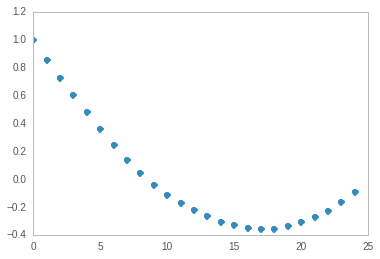

In [93]:
plt.acorr(delta_topics-np.mean(delta_topics),  normed=True, usevlines=False, maxlags=iters-1, label=u'Shuffled')
plt.xlim([0,iters])

###Topics as a Distribution over Words

- One important output of LDA is a matrix of topics where each topic is a distribution over the vocabulary.
- We want to verify that we observe only a few high-mass words per topic since we set our beta parameter to a small number (.5)

In [94]:
topic_words = defaultdict(lambda: [])
for d in xrange(n_docs): 
        for i, w in enumerate(word_indices(train_count_mat[d, :])):
            t = topics[d][i] 
            topic_words[t].append(inv_vocab_dict[w])

# Normalize
for topic in topic_words.keys():
    norm_topic_words = Counter(topic_words[topic])
    total = sum(norm_topic_words.values(), 0.0)
    for key in norm_topic_words:
        norm_topic_words[key] /= total
    topic_words[topic] = norm_topic_words

- Let's see what sort of topics LDA discovered. We will choose three topics at random

In [95]:
for i in np.random.choice(n_topics, 3):
    if topic_words[i]:
        sorted_topic_words = sorted(topic_words[i].items(), key=operator.itemgetter(1), reverse=True)
        print "\nMost important words for topic", i
        for word in sorted_topic_words[:10]:
            print word[0], word[1]


Most important words for topic 11
us 0.0192908165448
must 0.0130886693186
said 0.0110783181488
time 0.00988066213268
may 0.00962402155781
van 0.00893964669148
come 0.00851191240002
dr 0.00799863125027
though 0.00795585782112
helsing 0.00782753753368

Most important words for topic 12
project 0.011156462585
gutenbergtm 0.00810884353741
work 0.0058231292517
gutenberg 0.0050612244898
e 0.00489795918367
foundation 0.00484353741497
electronic 0.00484353741497
works 0.00484353741497
many 0.00478911564626
beowulf 0.00419047619048

Most important words for topic 13
bloom 0.0314162655181
stephen 0.0139346338992
like 0.0099315936154
o 0.0066886242716
street 0.00653661008361
old 0.00618191031163
zoe 0.00516848239169
mrs 0.00471243982772
mr 0.00471243982772
woman 0.00410438307575


* We can also visualize these topics as **wordclouds**

In [96]:
# wc = WordCloud(font_path="Verdana.ttf", background_color="white")
# wc.generate(" ".join([ (" " + word[0])*int(1000*word[1]) for word in topic_words[84].items()]))
# plt.imshow(wc)
# plt.axis("off")
# plt.title("Word cloud for Topic 84")
# plt.show()

# wc = WordCloud(font_path="Verdana.ttf", background_color="white")
# wc.generate(" ".join([ (" " + word[0])*int(1000*word[1]) for word in topic_words[32].items()]))
# plt.imshow(wc)
# plt.axis("off")
# plt.title("Word cloud for Topic 32")
# plt.show()

# wc = WordCloud(font_path="Verdana.ttf", background_color="white")
# wc.generate(" ".join([ (" " + word[0])*int(1000*word[1]) for word in topic_words[57].items()]))
# plt.imshow(wc)
# plt.axis("off")
# plt.title("Word cloud for Topic 57")
# plt.show()


- Because we set our parameters to ensure sparsity over topics, each topic should be only described by a few words. Let's see a histogram to verify that the sparsity constraint was realized.

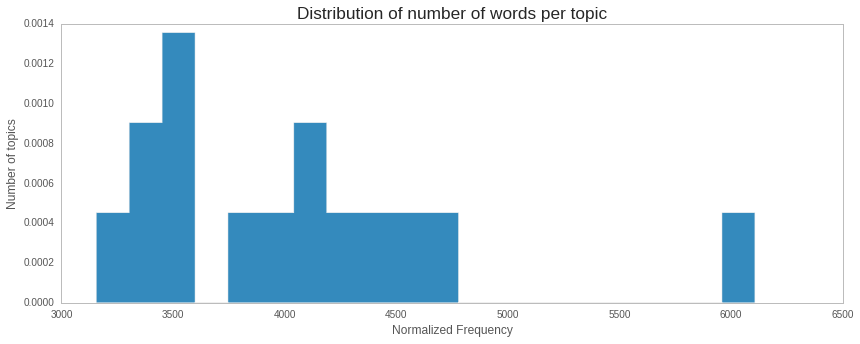

In [97]:
num_words_per_topic = [len(words) for topic, words in topic_words.iteritems()]
plt.figure(figsize=(14,5))
plt.hist(num_words_per_topic, bins=20, normed=True, histtype='stepfilled')
plt.title("Distribution of number of words per topic", fontsize="xx-large")
plt.xlabel("Normalized Frequency")
plt.ylabel("Number of topics")
plt.show()

### Documents as a Distribution over Topics

- Let's find our topic distributions over the train documents.
- We want to verify that we observe few high-mass topics per document since we set our alpha parameter to a large number (.8)

In [98]:
train_doc_topic_dist = np.zeros((n_docs, n_topics))
for d in xrange(n_docs): 
    # for each word
    for i, w in enumerate(word_indices(train_count_mat[d, :])):
        # get topic of mth document, ith word
        z = topics[d][i] 
        train_doc_topic_dist[d, z] += 1

# NORMALIZE TOPIC DISTRIBUTION
row_sums = train_doc_topic_dist.sum(axis=1)
train_doc_topic_dist = train_doc_topic_dist / row_sums[:, np.newaxis]

In [99]:
doc_topic_dist_df = pd.DataFrame(train_doc_topic_dist, columns=(["Topic " + str(i) for i in range(n_topics)]), index=([books[i] for i in range(n_docs)]))
doc_topic_dist_df

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14
beowulf.txt,0.040162,0.016558,0.063766,0.012154,0.000000,0.038048,0.000176,0.102607,0.114761,0.005901,0.009864,0.005196,0.555487,0.000000,0.035318
divine_comedy.txt,0.025513,0.010446,0.049051,0.223625,0.000636,0.037935,0.000502,0.022667,0.333144,0.011585,0.000000,0.003147,0.032276,0.000000,0.249473
dracula.txt,0.142026,0.043091,0.226215,0.012862,0.001256,0.029820,0.004533,0.002157,0.000000,0.081431,0.013654,0.410186,0.019252,0.000218,0.013299
frankenstein.txt,0.248357,0.051969,0.184183,0.030154,0.001381,0.087204,0.002209,0.005799,0.001436,0.003203,0.000000,0.015022,0.259679,0.000221,0.109184
huck_finn.txt,0.035547,0.019692,0.023455,0.000146,0.001717,0.003507,0.010412,0.000000,0.000000,0.240319,0.644125,0.007599,0.011508,0.000000,0.001973
moby_dick.txt,0.085093,0.043735,0.045168,0.044388,0.404350,0.027862,0.047544,0.129335,0.015056,0.045258,0.011609,0.025504,0.019319,0.000000,0.055779
sherlock_holmes.txt,0.256134,0.091447,0.252948,0.000497,0.001490,0.048620,0.074192,0.000000,0.000041,0.143460,0.006869,0.072992,0.030041,0.000166,0.021103
tale_of_two_cities.txt,0.292218,0.338746,0.109656,0.016373,0.002956,0.033838,0.031837,0.001501,0.000591,0.089371,0.011416,0.031882,0.007868,0.001865,0.029881
the_republic.txt,0.006778,0.234456,0.039891,0.018739,0.000000,0.587850,0.000021,0.004050,0.000567,0.019096,0.000000,0.018718,0.038632,0.000000,0.031203
ulysses.txt,0.074044,0.058944,0.058513,0.042671,0.012714,0.041161,0.129699,0.024254,0.007793,0.160775,0.033732,0.039934,0.021261,0.265302,0.029202


First, we can look at a heatmap of our topics over documents

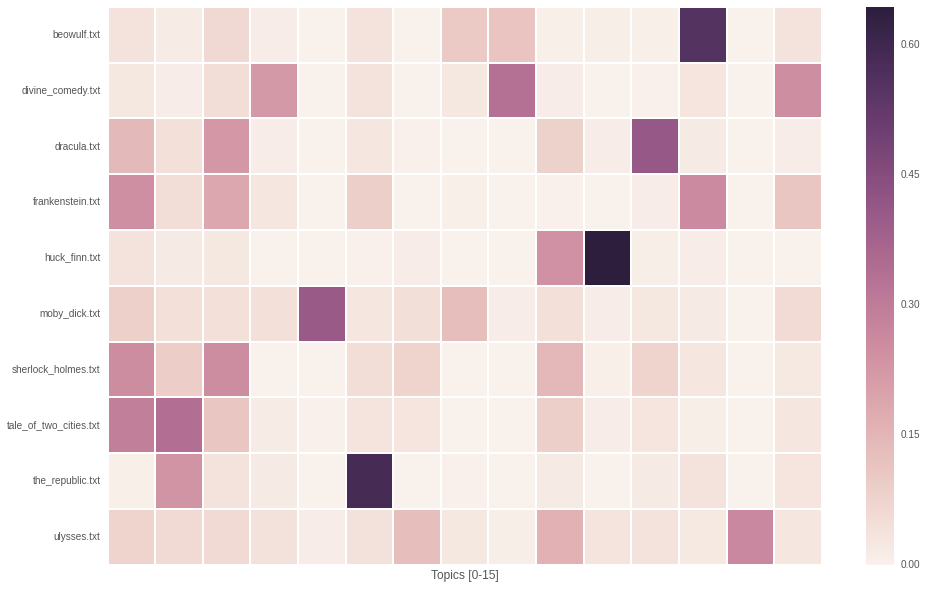

In [247]:
plt.figure(figsize=(16,10))
sns.heatmap(doc_topic_dist_df)
plt.gca().axes.get_xaxis().set_ticks([])
plt.xlabel("Topics [0-15]")
plt.show()

### 3D Visualization of Topic Density Across Documents

In [101]:
# # Create an init function and the animate functions.
# # Both are explained in the tutorial. Since we are changing
# # the the elevation and azimuth and no objects are really
# # changed on the plot we don't have to return anything from
# # the init and animate function. (return value is explained
# # in the tutorial.
# def init():
#     # Create a figure and a 3D Axes
#     fig = plt.figure(figsize=(10,5))
#     ax = Axes3D(fig)
#     xx,yy = np.meshgrid(np.arange(n_topics),np.arange(n_docs)) # Define a mesh grid in the region of interest
#     zz=train_doc_topic_dist
#     surf = ax.plot_surface(xx, yy, zz, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=False)
#     ax.view_init(elev=50., azim=250)
#     ax.set_zlim(0.0001, np.max(train_doc_topic_dist)*1.1)
#     ax.zaxis.set_major_locator(LinearLocator(10))
#     ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
#     ax.set_xlabel("Topics")
#     ax.set_ylabel("Documents")
#     fig.colorbar(surf, shrink=0.5, aspect=5)

# def animate(i):
#     ax.view_init(elev=5., azim=i)

# # Animate
# anim = animation.FuncAnimation(fig, animate, init_func=init,
#                                frames=360, interval=20, blit=True)
# # Save
# anim.save('topic_distributions.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

In [102]:
# from IPython.display import HTML
# from base64 import b64encode
# video = open("ipynb_assets/topic_distributions.mp4", "rb").read()
# video_encoded = b64encode(video)
# video_tag = '<video controls alt="test" src="data:video/x-m4v;base64,{0}">'.format(video_encoded)
# HTML(data=video_tag)

### 2D Histogram of Topics over Documents

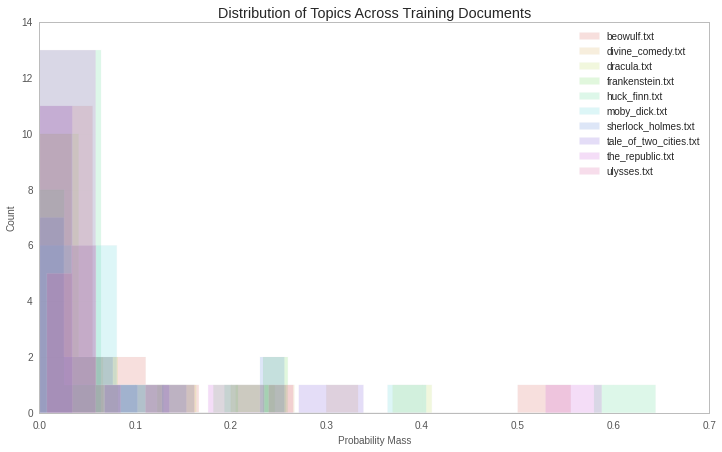

In [103]:
plt.figure(figsize=(12,7))
c = sns.color_palette("hls", n_docs)

for i in range(n_docs):
    plt.hist(train_doc_topic_dist[i, :], label=books[i], histtype="stepfilled", alpha=0.2, color=c[i])

plt.title("Distribution of Topics Across Training Documents")
plt.xlabel("Probability Mass", fontsize="medium")
plt.ylabel("Count", fontsize="medium")
plt.legend()
plt.show()

### Histogram of Topics Over Documents Individually

In [104]:
# plt.figure(figsize=(16,25))
# gs = gridspec.GridSpec(5, 2)
                       
# for i in range(len(books)):
#     ax = plt.subplot(gs[i])
#     ax.hist(train_doc_topic_dist[i, :], log=False)
#     ax.set_title("Topics by weight for %s" %(books[i]), fontsize="medium")
#     ax.set_xlabel("Probability Mass", fontsize="medium")
#     ax.set_ylabel("Count", fontsize="medium")

# plt.show()

# 5. Prediction

* We want to see if we can use a document's topic distribution as a <b>unique signature</b> for classification
* Our theory is that topics across a book will remain <b>consistent</b>
    * So if we take new, unseen data from one of the books, compute its topic distribution, and compare it to the training data's topic distributions, we can know which book the unseen data came from!
    
* First, we will use our trained model to infer topics for each of the test documents
    - we take the topic that maximizes the coniditional distribution, just as we did before.

In [105]:
test_doc_topic_dist = np.zeros((n_docs, n_topics))
for d in xrange(n_docs): 
    # for each word
    for i, w in enumerate(word_indices(test_count_mat[d, :])):
        # get topic of mth document, ith word
        p_z = conditional_dist(alpha, beta, nwt, nd, nt, d, w)
        z = np.random.multinomial(1,p_z).argmax()
        test_doc_topic_dist[d, z] += 1

# NORMALIZE TOPIC DISTRIBUTION
row_sums = test_doc_topic_dist.sum(axis=1) + 0.000001
test_doc_topic_dist = test_doc_topic_dist / row_sums[:, np.newaxis]

In [110]:
def create_topic_dist(test_count_mat):

    test_doc_topic_dist = np.zeros((n_docs, n_topics))
    for d in xrange(n_docs): 
        # for each word
        for i, w in enumerate(word_indices(test_count_mat[d, :])):
            # get topic of mth document, ith word
            p_z = conditional_dist(alpha, beta, nwt, nd, nt, d, w)
            z = np.random.multinomial(1,p_z).argmax()
            test_doc_topic_dist[d, z] += 1

    # NORMALIZE TOPIC DISTRIBUTION
    row_sums = test_doc_topic_dist.sum(axis=1) + 0.000001
    test_doc_topic_dist = test_doc_topic_dist / row_sums[:, np.newaxis]
    
    topic_distribution_norms = np.zeros((n_docs, n_docs))

    for i in xrange(n_docs):
        query_dist = test_doc_topic_dist[i, :]
        for j in xrange(n_docs):
            topic_distribution_norms[i, j] = np.linalg.norm(train_doc_topic_dist[j, :] - query_dist)

    return topic_distribution_norms

* We already have computed topic distributions over documents in our analysis, so now we can find the most similar topic distribution simply by computing the frobenius norm!

In [106]:
topic_distribution_norms = np.zeros((n_docs, n_docs))

for i in xrange(n_docs):
    query_dist = test_doc_topic_dist[i, :]
    for j in xrange(n_docs):
        topic_distribution_norms[i, j] = np.linalg.norm(train_doc_topic_dist[j, :] - query_dist)

mins = np.argmin(topic_distribution_norms, axis=1)
print mins

[0 1 2 3 4 5 6 7 8 9]


* Since the test documents are in order,  the indices should correspond to the label, which they do!

In [109]:
i = 0

probability_distance = [1/float(distance)/np.sum(1/topic_distribution_norms[i,:]) for distance in topic_distribution_norms[i,:]]
print probability_distance
print np.max(probability_distance)

[0.41868796088783888, 0.064987492758221993, 0.057666021965047706, 0.10819059233511756, 0.045242405380191676, 0.061046299536089067, 0.066559408180215954, 0.060295463492921884, 0.051837907150691163, 0.06548644831366407]
0.418687960888


In [ ]:
"Classification accuracy: %%%0.2f"%( 100*np.mean(np.array(books)[mins] == np.array(books)))

## Conclusion

- We train an LDA model on half the pages of ten classic books, the other half is used for testing
- Given the test data and our model, we perform inference on the new text to determine the topic distribution. We compare the queried topic distribution with our training data, and assign it to the closest match.
- Our hypothesis that thematic content would be a good signal for identifying texts was valid
    - We achieved a perfect classification of our query text
- Future work may use bigrams or n-grams to map to topics, instead of unigrams

In [209]:
def create_test_doc(k):
    # a start in the text
    # b end in the text
    test_docs, train_docs = [], []
    for doc in docs_as_nums:
        a = np.random.randint(0, len(doc)/2 - k - 1)
        test_docs.append(np.array(doc[a:a+k]))     #len(doc)/2]))
        train_docs.append(np.array(doc[len(doc)/2:]))
        
    test_docs, train_docs = np.array(test_docs), np.array(train_docs)
    return test_docs

In [240]:
list_k = [k for k in range(50, 2050, 50)]
it_mean = 30
probability_distance = [[] for i in range(len(list_k))]
i = 1

for j, k in enumerate(list_k):
    for nb_exp in range(it_mean):
        test_docs = create_test_doc(k)
        test_count_mat = np.array(map(freq_map, test_docs), dtype=np.int32)
        topic_distribution_norms = create_topic_dist(test_count_mat)
        probability_distance[j].append([1/float(distance)/np.sum(1/topic_distribution_norms[i,:]) for distance in topic_distribution_norms[i,:]])


In [241]:
mean_trace = []
var_trace = []

for p in range(len(list_k)):

    mean_trace.append(np.mean([probability_distance[p][j][i] for j in range(it_mean)]))
    var_trace.append(np.var([probability_distance[p][j][i] for j in range(it_mean)]))

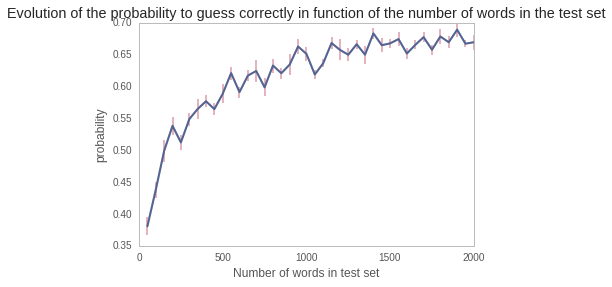

In [245]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(list_k, mean_trace)
plt.errorbar(list_k, mean_trace, yerr=[1.96*var for var in var_trace], alpha=0.3)
plt.title("Evolution of the probability to guess correctly in function of the number of words in the test set")
plt.ylabel('probability')
plt.xlabel('Number of words in test set')

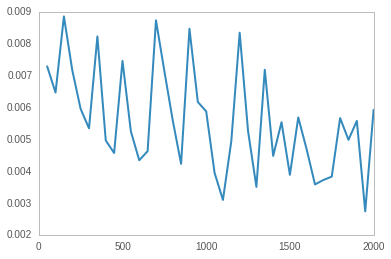

In [243]:
plt.plot(list_k, var_trace)

In [214]:
list_k2 = [k for k in range(1, 70, 5)]
it_mean = 10
probability_distance = [[] for i in range(len(list_k2))]
i = 1

for j, k in enumerate(list_k2):
    for nb_exp in range(it_mean):
        test_docs = create_test_doc(k)
        test_count_mat = np.array(map(freq_map, test_docs), dtype=np.int32)
        topic_distribution_norms = create_topic_dist(test_count_mat)
        probability_distance[j].append([1/float(distance)/np.sum(1/topic_distribution_norms[i,:]) for distance in topic_distribution_norms[i,:]])


In [215]:
mean_trace2 = []
var_trace2 = []

for p in range(len(list_k2)):

    mean_trace2.append(np.mean([probability_distance[p][j][i] for j in range(it_mean)]))
    var_trace2.append(np.var([probability_distance[p][j][i] for j in range(it_mean)]))

<Container object of 3 artists>

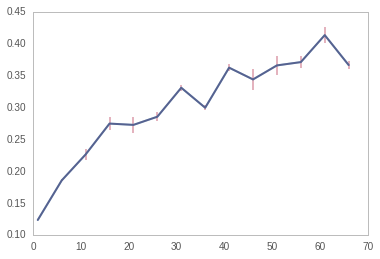

In [216]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(list_k2, mean_trace2)
plt.errorbar(list_k2, mean_trace2, yerr=[1.96*var for var in var_trace2], alpha=0.3)

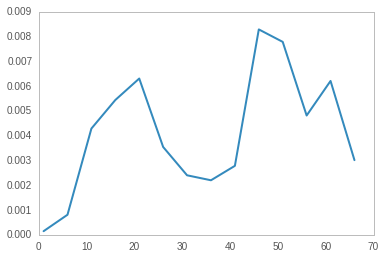

In [217]:
plt.plot(list_k2, var_trace2)

In [ ]:
list_k3 = [k for k in range(2000, 13000, 500)]
it_mean = 10
probability_distance = [[] for i in range(len(list_k3))]
i = 1

for j, k in enumerate(list_k3):
    for nb_exp in range(it_mean):
        test_docs = create_test_doc(k)
        test_count_mat = np.array(map(freq_map, test_docs), dtype=np.int32)
        topic_distribution_norms = create_topic_dist(test_count_mat)
        probability_distance[j].append([1/float(distance)/np.sum(1/topic_distribution_norms[i,:]) for distance in topic_distribution_norms[i,:]])


In [ ]:
mean_trace3 = []
var_trace3 = []

for p in range(len(list_k3)):

    mean_trace3.append(np.mean([probability_distance[p][j][i] for j in range(it_mean)]))
    var_trace3.append(np.var([probability_distance[p][j][i] for j in range(it_mean)]))

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(list_k3, mean_trace3)
plt.errorbar(list_k3, mean_trace3, yerr=[1.96*var for var in var_trace3], alpha=0.3)

In [ ]:
plt.plot(list_k3, var_trace3)

In [227]:
?k